In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[3])

import jax.numpy as jnp
from KernelTools import make_block,eval_k,vectorize_kfunc,diagpart,get_selected_grad
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel,get_matern
from data_utils import build_xy_grid
from darcy_data import get_darcy_solver,sample_gp_function
from jax.random import PRNGKey as pkey
import matplotlib.pyplot as plt
from EquationModel import CholInducedRKHS,SharedOperatorPDEModel,InducedOperatorModel,AltCholInducedRKHS
from tqdm.auto import tqdm
from parabolic_data_utils import build_alpha_chebyshev
from data_utils import make_grids

In [2]:
num_functions = 20
samples_per_function = 10
collocation_grid_n = 16

obs_random_keys = jax.random.split(pkey(32),num_functions)
xy_obs = tuple(jax.random.uniform(key,(samples_per_function,2),minval = 0.,maxval = 1.) for key in obs_random_keys)


kernel_f = get_gaussianRBF(0.15)
key = pkey(10)
keys = jax.random.split(key,num_functions)
rhs_functions = tuple(
    sample_gp_function(subkey,kernel_f) for subkey in keys
)

grid = jnp.linspace(0,1,100)
x,y = jnp.meshgrid(grid,grid)
fine_grid = jnp.vstack([x.flatten(),y.flatten()]).T
loga = sample_gp_function(jax.random.PRNGKey(124),get_matern(2,0.5))
def a(x):
    return jnp.exp(0.25 * loga(x))

# def a(x):
#     return 0.1 * jnp.exp(0.5 * jnp.sin(4*jnp.pi*x[0]*x[1]))

darcy_solve = get_darcy_solver(a,num_grid = 50,k_u = get_gaussianRBF(0.1))
u_true_functions = tuple([darcy_solve(f) for f in rhs_functions])

single_grid = build_alpha_chebyshev([0,1],collocation_grid_n,1.)
xy_int,xy_bdy = make_grids(single_grid,single_grid)
xy_all = jnp.vstack([xy_int,xy_bdy])

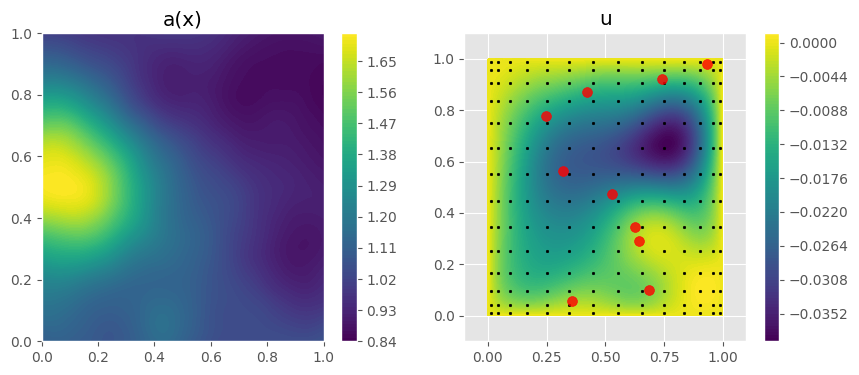

In [3]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('a(x)')
plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(a)(fine_grid),100)
plt.colorbar()

plt.subplot(1,2,2)
plt.title('u')
plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(u_true_functions[0])(fine_grid),100)
plt.colorbar()
plt.scatter(xy_int[:,0],xy_int[:,1],c = 'black',s = 3)
plt.scatter(xy_obs[0][:,0],xy_obs[0][:,1],c = 'red',s = 50,alpha = 0.8)
# plt.scatter(xy_bdy[:,0],xy_bdy[:,1],c = 'red',s = 50,alpha = 0.8)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [17]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])
basis_operators = tuple([eval_k,diff_xx_op,diff_yy_op])
basis_operators = feature_operators

k_u = get_gaussianRBF(0.25)
u_model = CholInducedRKHS(
    xy_all,
    basis_operators,
    k_u
)

observation_points = tuple(jnp.vstack([xy_bdy,obs]) for obs in xy_obs)
observation_values = tuple(jax.vmap(u)(obs_loc) for u,obs_loc in zip(u_true_functions,observation_points))
collocation_points = (xy_int,)*num_functions

rhs_values = tuple(jax.vmap(rhs_func)(int_points) for rhs_func,int_points in zip(rhs_functions,collocation_points))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val) 
    for obs_loc,obs_val in zip(observation_points,observation_values)
    ]
    )

grid_features_u_init = [(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for model_params in all_u_params_init
        ]
grid_features_u_init = jnp.vstack([jnp.hstack([xy_int,features]) for features in grid_features_u_init])

num_P_inducing = 250
input_feature_sample = jax.random.choice(pkey(320),grid_features_u_init,(num_P_inducing,))
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_matern(2,0.25)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

P_model = InducedOperatorModel(input_feature_sample,k_P)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

In [18]:
params_init = jnp.hstack(list(all_u_params_init)+[P_init])

u_init = jnp.stack(all_u_params_init)
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 10.,
    num_P_operator_params=num_P_inducing
)
beta_reg = 1e-12

In [19]:
from Optimizers import BlockArrowLM,LMParams
lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-8)
u_sol,P_sol,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0169, gradnorm = 1.95, alpha = 0.08333, improvement_ratio = 1.005
Iteration 1, loss = 0.01066, gradnorm = 0.0599, alpha = 0.06944, improvement_ratio = 1.035
Iteration 2, loss = 0.007716, gradnorm = 0.0367, alpha = 0.05787, improvement_ratio = 1.033
Iteration 3, loss = 0.005902, gradnorm = 0.02195, alpha = 0.04823, improvement_ratio = 1.028
Iteration 4, loss = 0.004672, gradnorm = 0.01597, alpha = 0.04019, improvement_ratio = 1.022
Iteration 5, loss = 0.003809, gradnorm = 0.01252, alpha = 0.03349, improvement_ratio = 1.017
Iteration 50, loss = 3.104e-05, gradnorm = 0.004311, alpha = 1.319e-05, improvement_ratio = 0.8354
Iteration 100, loss = 7.812e-06, gradnorm = 0.001017, alpha = 2.556e-06, improvement_ratio = 0.7236
Iteration 150, loss = 1.234e-06, gradnorm = 0.000224, alpha = 8.972e-09, improvement_ratio = 0.8612
Iteration 200, loss = 5.348e-07, gradnorm = 2.588e-06, alpha = 8.333e-09, improvement_ratio = 1.001
Iteration 250, loss = 4.416e-07, gradnorm = 4.929e-

In [20]:
grid = jnp.linspace(0.,1.,50)
x,y = jnp.meshgrid(grid,grid)
fine_grid_int = jnp.vstack([x.flatten(),y.flatten()]).T

def get_percent_errors(u_params):
    #Have to loop since u_true_functions are just callables
    percent_errors = []
    for i in range(num_functions):
        u_vals = u_model.point_evaluate(fine_grid_int,u_params[i])
        u_true_vals = jax.vmap(u_true_functions[i])(fine_grid_int)
        percent_errors.append(jnp.linalg.norm(u_vals - u_true_vals)/jnp.linalg.norm(u_true_vals))
    percent_errors = jnp.array(percent_errors)
    return percent_errors

onestep_errors = get_percent_errors(u_sol)
interp_errors = get_percent_errors(u_init)
print("Onestep ",jnp.mean(onestep_errors))
print("Interpolant ",jnp.mean(interp_errors))
print("Average Ratio: ",jnp.mean(interp_errors/onestep_errors))

Onestep  0.03879890684244693
Interpolant  0.48516240895100016
Average Ratio:  11.162326384944654


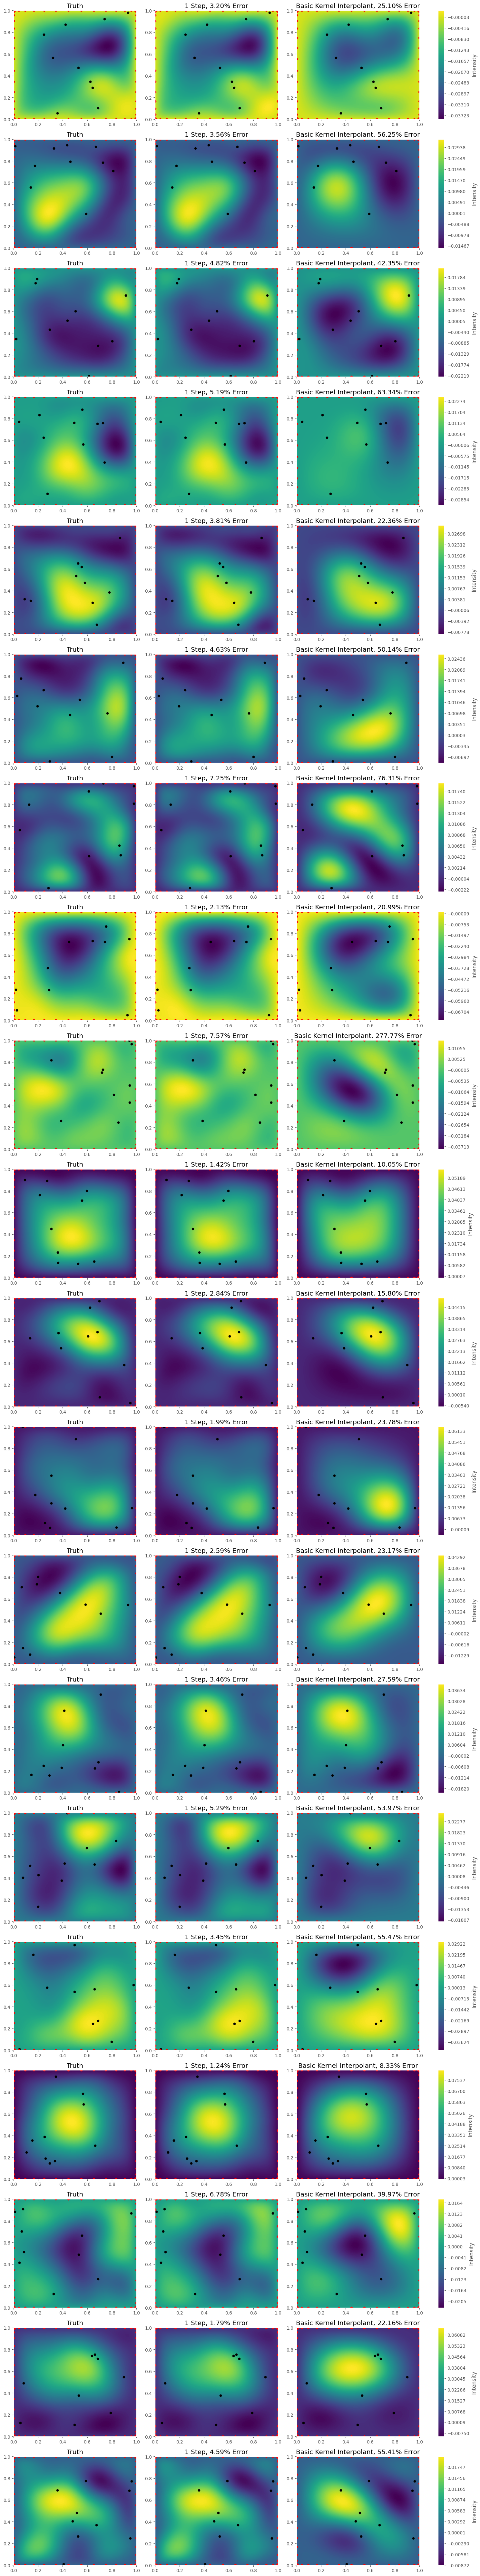

In [21]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 4 * num_functions))
gs = gridspec.GridSpec(num_functions, 4, width_ratios=[1, 1, 1, 0.05])  # Last column for colorbar

for i in range(num_functions):
    # Get the subplots for this row
    ax1 = plt.subplot(gs[i, 0])
    ax2 = plt.subplot(gs[i, 1])
    ax3 = plt.subplot(gs[i, 2])
    cbar_ax = plt.subplot(gs[i, 3])  # Colorbar axis

    # Compute the values
    u_vals_1step = u_model.point_evaluate(fine_grid_int, u_sol[i])
    u_vals_interp = u_model.point_evaluate(fine_grid_int, u_init[i])
    u_true_vals = jax.vmap(u_true_functions[i])(fine_grid_int)

    # Determine the levels for consistent color mapping across subplots in the same row
    lower = jnp.min(jnp.vstack([u_vals_1step, u_vals_interp, u_true_vals]))
    upper = jnp.max(jnp.vstack([u_vals_1step, u_vals_interp, u_true_vals]))
    levels = jnp.linspace(lower, upper + 1e-4, 200)

    # First subplot: Truth
    ax1.set_title("Truth")
    contour_truth = ax1.tricontourf(fine_grid_int[:, 0], fine_grid_int[:, 1], u_true_vals, levels=levels)
    ax1.scatter(xy_obs[i][:, 0], xy_obs[i][:, 1], c='black', s=25)
    ax1.scatter(xy_bdy[:, 0], xy_bdy[:, 1], c='red', s=25)

    # Second subplot: 1 Step Solution
    ax2.set_title(f"1 Step, {100 * onestep_errors[i]:.2f}% Error")
    contour_1step = ax2.tricontourf(fine_grid_int[:, 0], fine_grid_int[:, 1], u_vals_1step, levels=levels)
    ax2.scatter(xy_obs[i][:, 0], xy_obs[i][:, 1], c='black', s=25)
    ax2.scatter(xy_bdy[:, 0], xy_bdy[:, 1], c='red', s=25)

    # Third subplot: Basic Kernel Interpolant
    ax3.set_title(f"Basic Kernel Interpolant, {100 * interp_errors[i]:.2f}% Error")
    contour_interp = ax3.tricontourf(fine_grid_int[:, 0], fine_grid_int[:, 1], u_vals_interp, levels=levels)
    ax3.scatter(xy_obs[i][:, 0], xy_obs[i][:, 1], c='black', s=25)
    ax3.scatter(xy_bdy[:, 0], xy_bdy[:, 1], c='red', s=25)

    # Add colorbar for this row
    cbar = fig.colorbar(contour_interp, cax=cbar_ax)
    cbar_ax.set_ylabel('Intensity')  # Label for colorbar

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



In [ ]:
import pde_solvers.kernel_elliptic
import Optimizers.solvers_base
from importlib import reload
reload(Optimizers.solvers_base)
reload(pde_solvers.kernel_elliptic)
from pde_solvers.kernel_elliptic import EllipticPDEModel

evaluation_key = pkey(10)
num_evaluation_functions = 10
kernel_f = get_gaussianRBF(0.15)
keys = jax.random.split(evaluation_key,num_evaluation_functions)

rhs_functions_eval = tuple(
    sample_gp_function(subkey,kernel_f) for subkey in keys
)
darcy_solve = get_darcy_solver(a,num_grid = 50,k_u = get_gaussianRBF(0.2))
u_true_fine = tuple([jax.vmap(darcy_solve(f))(fine_grid) for f in tqdm(rhs_functions_eval)])

k_u = get_gaussianRBF(0.2)
solver_params = LMParams(max_iter = 501,init_alpha = 1e-4,min_alpha = 1e-8,use_jit = False,show_progress=False)


onestep_P = lambda x:P_model.predict(x,P_sol)
onestep_solver = EllipticPDEModel(
    get_gaussianRBF(0.2),onestep_P,
    feature_operators,num_grid = 30,solverParams=solver_params
    )

twostep_P = lambda x:P_model.predict(x,P_init)
twostep_solver = EllipticPDEModel(
    get_gaussianRBF(0.2),twostep_P,
    feature_operators,num_grid = 30,
    solverParams=solver_params
    )
#onestep_solutions = []

  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
def solve_evaluate(solver,rhs_func,grid):
    pde_u,pde_params,conv = solver.solve(rhs_func)
    return pde_u.point_evaluate(grid,pde_params)

In [34]:
onestep_solutions = [solve_evaluate(onestep_solver,rhs_f,fine_grid) for rhs_f in rhs_functions_eval]
twostep_solutions = [solve_evaluate(twostep_solver,rhs_f,fine_grid) for rhs_f in rhs_functions_eval]

In [35]:
onestep_operator_errors = jnp.array([jnp.linalg.norm(uu - u_one)/jnp.linalg.norm(uu) for uu,u_one in zip(u_true_fine,onestep_solutions)])
twostep_operator_errors = jnp.array([jnp.linalg.norm(uu - u_two)/jnp.linalg.norm(uu) for uu,u_two in zip(u_true_fine,twostep_solutions)])

In [67]:
onestep_operator_errors

Array([0.03336944, 0.02482176, 0.04023309, 0.03083539, 0.04407842,
       0.05049909, 0.03585099, 0.06475357, 0.08101611, 0.06728469],      dtype=float64)

In [68]:
twostep_operator_errors

Array([0.20471269, 0.38797343, 0.98837013, 0.33419576, 0.79494135,
       0.68111721, 0.62305246, 1.47491123, 0.58732617, 1.35849707],      dtype=float64)

In [60]:
onestep_forward_errors = []
twostep_forward_errors = []

for i in range(num_evaluation_functions):
    sol = darcy_solve(rhs_functions_eval[i])
    rhs_values = jax.vmap(rhs_functions_eval[i])(fine_grid_int)
    true_input_features = jnp.vstack([fine_grid_int.T] + [jax.vmap(op(sol,0))(fine_grid_int) for op in feature_operators]).T
    onestep_forward_errors.append(jnp.linalg.norm(rhs_values - onestep_P(true_input_features))/jnp.linalg.norm(rhs_values))
    twostep_forward_errors.append(jnp.linalg.norm(rhs_values - twostep_P(true_input_features))/jnp.linalg.norm(rhs_values))

onestep_forward_errors = jnp.array(onestep_forward_errors)
twostep_forward_errors = jnp.array(twostep_forward_errors)

In [64]:
onestep_forward_errors

Array([0.18156008, 0.18970759, 0.13207179, 0.13461877, 0.13152404,
       0.18082975, 0.16030958, 0.16202475, 0.18178499, 0.18275452],      dtype=float64)

In [65]:
twostep_forward_errors

Array([0.66253269, 0.83162627, 0.6825564 , 0.54917434, 0.52213941,
       0.60089713, 0.63088156, 0.73774001, 0.80683369, 0.85916152],      dtype=float64)